# Exam text analysis 
Sarah Hsu (8264937)

### Question 1 
Train a topic model on the description column in framing.p. Describe and explain your pre-processing steps and parameters.
Choose two news media from the column netloc (e.g. vox.com and breit- bart.com) that are relevant to compare and explain your choice. Compare the topic proportions between those two news media. Try to explain your results, also given what you know about how the data set is constructed.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from pandas import DataFrame
framing = pd.read_pickle('/content/drive/MyDrive/B2_Data Mining/Data/framing.p')
framing.head()

,tweet_id,date,user,party,state,chamber,tweet,news_mention,url_reference,netloc,title,description,label
0,1325914751495499776,2020-11-09 21:34:45,SenShelby,R,Alabama,Senator,ICYMI – @BusinessInsider declared #Huntsville ...,businessinsider,https://www.businessinsider.com/personal-finan...,www.businessinsider.com,The 10 best US cities to move to if you want t...,The best US cities to move to if you want to s...,
1,1294021087118987264,2020-08-13 21:20:43,SenShelby,R,Alabama,Senator,Great news! Today @mazda_toyota announced an a...,,https://pressroom.toyota.com/mazda-and-toyota-...,pressroom.toyota.com,Mazda and Toyota Further Commitment to U.S. Ma...,"HUNTSVILLE, Ala., (Aug. 13, 2020) – Today, Maz...",
2,1323340848130609156,2020-11-02 19:06:59,DougJones,D,Alabama,Senator,He’s already quitting on the folks of Alabama ...,,https://apnews.com/article/c73f0dfe8008ebaf85e...,apnews.com,"Tuberville, Jones fight for Senate seat in Ala...","GARDENDALE, Ala. (AP) — U.S. Sen. Doug Jones, ...",
3,1323004075831709698,2020-11-01 20:48:46,DougJones,D,Alabama,Senator,I know you guys are getting bombarded with fun...,,https://secure.actblue.com/donate/djfs-close?r...,secure.actblue.com,I just gave!,Join us! Contribute today.,negiotated
4,1322567531320717314,2020-10-31 15:54:06,DougJones,D,Alabama,Senator,"Well looky here folks, his own players don’t t...",,https://slate.com/culture/2020/10/tommy-tuberv...,slate.com,What Tommy Tuberville’s Former Auburn Players ...,"""All I could think is, why?""",


In [3]:
# Take a look at the netloc column
framing.netloc.value_counts().head(50)

www.nytimes.com               1508
                              1092
www.politico.com               623
www.cnn.com                    602
thehill.com                    550
www.foxnews.com                549
www.nbcnews.com                485
nyti.ms                        422
www.cnbc.com                   342
cnn.it                         341
secure.actblue.com             292
apnews.com                     266
hill.cm                        177
trib.al                        177
www.latimes.com                175
apne.ws                        163
abcn.ws                        141
www.vox.com                    141
www.cbsnews.com                140
www.theatlantic.com            138
www.axios.com                  136
nbcnews.to                     133
www.foxbusiness.com            130
www.washingtonexaminer.com     128
nypost.com                     128
www.reuters.com                123
buff.ly                        118
www.dallasnews.com             112
abcnews.go.com      

### *Motivation of the two news media (50 words)
I decide to choose the online media of 'www.foxbusiness.com' and 'www.businessinsider.com' because the both platforms are generally discuss about business topics but with different location bases. Fox Business is launched by American company and more financial reports are related to American business, whereas the Business Insider are more based on Europe economy. They are both business-oriented media but with different background by regions. I think it will be interesting to gain insight into their relationship between different topics as well as the similarity within same topic.

In [ ]:
# Pre-processing with Spacy package
import spacy
alldesc = framing.description.values

nlp = spacy.load("en_core_web_sm")
processed_texts = [text for text in nlp.pipe(alldesc, 
                                              disable=["ner",
                                                       "parser"])]
framing['processed_texts'] = processed_texts #add processed_texts to a new column

# Tokenization, lemmatization, removing stop word, removing punctuations and filtering word type(nouns)
tokenized_texts_desc = [[word.lemma_.lower() for word in processed_text if word.pos_ == 'NOUN' 
                                and not word.is_stop and not word.is_punct] for processed_text in processed_texts]

In [ ]:
# Vectorization
from gensim.corpora import Dictionary

# Create a dictionary and filter out the words that occur less than two times, and all words that occur in over 70% of the documents.
MIN_DF = 2 # minium document frequency
MAX_DF = 0.7 # maximum document frequency

tokenized_texts = tokenized_texts_desc
dictionary = Dictionary(tokenized_texts) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

### *Explanation of preprocessing steps + parameters (150 words)
In order to train a topic model on the description column, firstly, I tokenize the texts in description with Spacy package.

To have clear tokens without unmeaningful words and repetitive words, I remove stop word and do lemmatization to analyze the words with the same root. Additionally, I only select the noun word type because it is much easier to look into the subjects and topics discussion in the sentiences. Finally, I put the all the above functions together to make the code clear and save some time.

After I get the tokens, I do vectorization and create a dictionary.
I set two parameters to select the frequency of a word. I set `MIN_DF = 2` – only keep a word occurring in at least two documents that we can see the relation between different topics. `MAX_DF = 0.7` -- only include a word has to occur in less than 70% of the document that we can filter out some words are not useful.


### Train a topic model with description

In [ ]:
import os   

!pip uninstall gensim
!pip install gensim==3.8.3

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    
  !java -version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

!python -m spacy download nl_core_news_sm

In [ ]:
# Train the topic model
from gensim.models.wrappers import LdaMallet

PATH_TO_MALLET = 'mallet-2.0.8/bin/mallet'

N_TOPICS = 8 # k = 8: run a topic model with 8 topics
N_ITERATIONS = 1000

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10, 
                iterations=N_ITERATIONS) 

In [ ]:
# Show the top 10 words with the highest probabilities in the first topic:
TOPIC = 0 # choose the first topic
MAX_WORDS = 10 # get 10 words
words = lda.show_topic(TOPIC, topn=MAX_WORDS) 

# Put it into a DataFrame
words = lda.show_topic(TOPIC, topn=len(dictionary)) # get all the words
df = pd.DataFrame(words, columns=['word', 'prop']) 
df.sort_values('prop', ascending=False).head()

,word,prop
0,case,0.030320
1,state,0.029322
2,week,0.024456
3,pandemic,0.022771
4,people,0.019589


In [ ]:
# Show the key words in each topic
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: case state week pandemic people administration official number country unemployment
Topic 1: member president veteran policy issue nominee intelligence service group leader
Topic 2: election mail ballot voter voting vote official state today woman
Topic 3: school student year family child woman information decade time million
Topic 4: health care vaccine people pandemic study percent drug flu virus
Topic 5: bill relief year business support legislation state pandemic program crisis
Topic 6: police news city officer fire day year people night organization
Topic 7: climate company program year administration change industry energy state country


I find there are some overlaps of words between topics if I select too much topics. So I just set `N_TOPICS = 8` to get only 8 topics but with notable features in each one.

In order to make it easiler to see the relationship in the following analysis, I give a label to these topics based on the key words in each topics above. Topic 0:society. 1:policy. 2: election. 3: education. 4: health. 5: economic. 6:employment 7:climate.

##Comparing the topics between Fox Business and Business Insider

In [ ]:
import pandas as pd
label = {0:'society', 1:'policy', 2: 'election', 3: 'education', 4: 'health', 5: 'economic', 6:'employment', 7:'climate'}

transformed_docs = lda.load_document_topics()

# Put the labels into DataFrame
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=[label[i] for i in range(N_TOPICS)])
topic_distributions.head()

,society,policy,election,education,health,economic,employment,climate
0,0.023576,0.020257,0.032610,0.015734,0.017013,0.845032,0.023556,0.022222
1,0.004618,0.003968,0.006387,0.003082,0.003332,0.004689,0.004614,0.969310
2,0.016714,0.014361,0.023118,0.884318,0.012061,0.016973,0.016700,0.015754
3,0.023576,0.020257,0.032610,0.426280,0.017013,0.434486,0.023556,0.022222
4,0.023576,0.020257,0.032610,0.015734,0.427558,0.023941,0.023556,0.432767


In [ ]:
# Combine netlog(Fox Business & Business Insider) and topic_distributions to analyze the differences
framing2 = framing[(framing.netloc == 'www.foxbusiness.com') | (framing.netloc =='www.businessinsider.com')]
framing2 = framing2[['netloc','description','processed_texts']]

joined_topic_dist = framing2.reset_index().join(topic_distributions)
joined_topic_dist.head()

,index,netloc,description,processed_texts,society,policy,election,education,health,economic,employment,climate
0,0,www.businessinsider.com,The best US cities to move to if you want to s...,"(The, best, US, cities, to, move, to, if, you,...",0.023576,0.020257,0.032610,0.015734,0.017013,0.845032,0.023556,0.022222
1,148,www.foxbusiness.com,EXCLUSIVE: The Paycheck Protection Program sup...,"(EXCLUSIVE, :, The, Paycheck, Protection, Prog...",0.004618,0.003968,0.006387,0.003082,0.003332,0.004689,0.004614,0.969310
2,240,www.foxbusiness.com,When we launched Operation Warp Speed (OWS) sk...,"(When, we, launched, Operation, Warp, Speed, (...",0.016714,0.014361,0.023118,0.884318,0.012061,0.016973,0.016700,0.015754
3,421,www.foxbusiness.com,The Labor Department's payroll report released...,"(The, Labor, Department, 's, payroll, report, ...",0.023576,0.020257,0.032610,0.426280,0.017013,0.434486,0.023556,0.022222
4,429,www.foxbusiness.com,Sen. Martha McSally wants to make China pay th...,"(Sen., Martha, McSally, wants, to, make, China...",0.023576,0.020257,0.032610,0.015734,0.427558,0.023941,0.023556,0.432767


In [ ]:
# Compare the mean topic proportions of Fox Business and Business Insider
grouped_by_netloc = joined_topic_dist.groupby('netloc').mean()
grouped_by_netloc.head()

,index,society,policy,election,education,health,economic,employment,climate
netloc,,,,,,,,,
www.businessinsider.com,14786.194030,0.098390,0.082508,0.164282,0.061943,0.087757,0.147451,0.233196,0.124474
www.foxbusiness.com,17659.653846,0.117665,0.108417,0.135362,0.116257,0.062853,0.127017,0.203259,0.129171


### Visdualization

In [ ]:
!pip install matplotlib

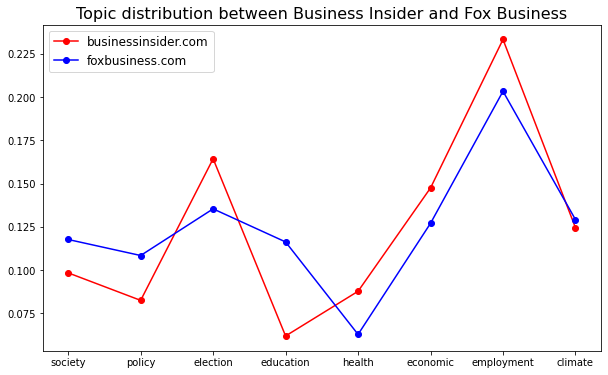

In [ ]:
# Visdualization the relationship
import matplotlib.pyplot as plt

media = grouped_by_netloc.transpose()

plt.figure(figsize=(10,6))
plt.plot(media.iloc[1:,0], label= "businessinsider.com", color='red', marker='o')
plt.plot(media.iloc[1:,1], label= "foxbusiness.com", color='blue', marker='o')

plt.title('Topic distribution between Business Insider and Fox Business', fontsize=16)
plt.legend(fontsize=12)
plt.show()

###*Interpretation and discussion (ca. 200 words)
Given a label to each topic, we can clearly see the topic distribution between Business Insider and Fox Business in the eight topics [society, policy, election, education, health, economic, employment, climate].
First, as both of Business Insider and Fox Business are business-oriented platforms, it is striking that they have the similar topic distribution across thses topics. Additionally, they both have the highest proportions in discussing employment and election whereas lower proportions in health issues. In this case, I assuem that a majority of people reviewing these two media are more focus on the infomation of employment and election news.

However, there are also some notable differeces between the two media. For example, Business Insider care much less about education topic compared to Fox Business which still hold at average level in general. In my opinion, the reason might according to their regions with different educational policies and culture between America and Europe.  

In conclution, with topic modeling method, we can look into the main issues in a medium. Furthermore, we can compare the topic distribution with another medium which we are curious about. It provides us useful data to shed lights on the relationship between media and topics in diverse aspects.